In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime

from datetime import timedelta, date
import time
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
code_dir = os.path.realpath(os.path.join(os.getcwd(), ".."))

import sys
sys.path.append(code_dir)

from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, query_starboard_sector_expirations
from mechafil.power import forecast_power_stats, build_full_power_stats_df
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df
from mechafil.supply import forecast_circulating_supply_df

In [3]:
# for time-series prediction - SGT model
#  https://num.pyro.ai/en/stable/tutorials/time_series_forecasting.html 

import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.diagnostics import autocorrelation, hpdi
from numpyro.infer import MCMC, NUTS, Predictive

import jax.numpy as jnp
import jax.random as random
from numpyro.infer import MCMC, NUTS, Predictive

def sgt(y, seasonality, future=0):
    # heuristically, standard derivation of Cauchy prior depends on
    # the max value of data
    cauchy_sd = jnp.max(y) / 150
    # NB: priors' parameters are taken from
    # https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/R/rlgtcontrol.R
    nu = numpyro.sample("nu", dist.Uniform(2, 20))
    powx = numpyro.sample("powx", dist.Uniform(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(cauchy_sd))
    offset_sigma = numpyro.sample(
        "offset_sigma", dist.TruncatedCauchy(low=1e-10, loc=1e-10, scale=cauchy_sd)
    )

    coef_trend = numpyro.sample("coef_trend", dist.Cauchy(0, cauchy_sd))
    pow_trend_beta = numpyro.sample("pow_trend_beta", dist.Beta(1, 1))
    # pow_trend takes values from -0.5 to 1
    pow_trend = 1.5 * pow_trend_beta - 0.5
    pow_season = numpyro.sample("pow_season", dist.Beta(1, 1))

    level_sm = numpyro.sample("level_sm", dist.Beta(1, 2))
    s_sm = numpyro.sample("s_sm", dist.Uniform(0, 1))
    init_s = numpyro.sample("init_s", dist.Cauchy(0, y[:seasonality] * 0.3))

    def transition_fn(carry, t):
        level, s, moving_sum = carry
        season = s[0] * level**pow_season
        exp_val = level + coef_trend * level**pow_trend + season
        exp_val = jnp.clip(exp_val, a_min=0)
        # use expected vale when forecasting
        y_t = jnp.where(t >= N, exp_val, y[t])

        moving_sum = (
            moving_sum + y[t] - jnp.where(t >= seasonality, y[t - seasonality], 0.0)
        )
        level_p = jnp.where(t >= seasonality, moving_sum / seasonality, y_t - season)
        level = level_sm * level_p + (1 - level_sm) * level
        level = jnp.clip(level, a_min=0)

        new_s = (s_sm * (y_t - level) / season + (1 - s_sm)) * s[0]
        # repeat s when forecasting
        new_s = jnp.where(t >= N, s[0], new_s)
        s = jnp.concatenate([s[1:], new_s[None]], axis=0)

        omega = sigma * exp_val**powx + offset_sigma
        y_ = numpyro.sample("y", dist.StudentT(nu, exp_val, omega))

        return (level, s, moving_sum), y_

    N = y.shape[0]
    level_init = y[0]
    s_init = jnp.concatenate([init_s[1:], init_s[:1]], axis=0)
    moving_sum = level_init
    with numpyro.handlers.condition(data={"y": y[1:]}):
        _, ys = scan(
            transition_fn, (level_init, s_init, moving_sum), jnp.arange(1, N + future)
        )
    if future > 0:
        numpyro.deterministic("y_forecast", ys[-future:])

## 1. Parameters and other variables

In [4]:
# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

# Today is 2022-11-01  # TODO: update
current_date = datetime.date(2022, 11, 1)   
current_day = (current_date - datetime.date(2020, 10, 15)).days

start_date = datetime.date(2021, 3, 15)
start_day = (start_date - datetime.date(2020, 10, 15)).days

# Forecast is one year ahead from today
forecast_lenght = 365*2
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)

2021-03-15
2022-11-01
2024-10-31


## 2. Input data

#### Sector scheduled expirations

In [5]:
res = get_sector_expiration_stats(start_date, current_date,end_date)

rb_known_scheduled_expire_vec = res[0]
qa_known_scheduled_expire_vec = res[1]
known_scheduled_pledge_release_full_vec = res[2]

#### Daily network stats

In [6]:
fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)

current_day_stats = fil_stats_df[fil_stats_df["date"] >= current_date].iloc[0]
current_day_stats

circulating_fil               384714480.309213
mined_fil                     233855840.958391
vested_fil                    301765965.131562
locked_fil                    134508108.842877
burnt_fil                      33465835.899636
date                                2022-11-01
total_raw_power_eib                  16.017958
total_qa_power_eib                    18.62947
day_onboarded_rb_power_pib            9.735138
day_onboarded_qa_power_pib           25.884187
day_renewed_qa_power_pib            117.858355
Name: 595, dtype: object

In [7]:
fil_stats_df

,circulating_fil,mined_fil,vested_fil,locked_fil,burnt_fil,date,total_raw_power_eib,total_qa_power_eib,day_onboarded_rb_power_pib,day_onboarded_qa_power_pib,day_renewed_qa_power_pib
0,1.011143e+08,4.294468e+07,1.093991e+08,4.913035e+07,1.916571e+07,2021-03-16,3.310809,3.311754,31.176788,30.780540,0.000000
1,1.016796e+08,4.329793e+07,1.100472e+08,4.953880e+07,1.919340e+07,2021-03-17,3.341048,3.341986,32.155762,31.852937,0.000000
2,1.022119e+08,4.364709e+07,1.106954e+08,4.994090e+07,1.925624e+07,2021-03-18,3.369592,3.370540,31.870209,31.465290,0.000000
3,1.027568e+08,4.399606e+07,1.113435e+08,5.034152e+07,1.930788e+07,2021-03-19,3.396884,3.397818,31.849304,31.453568,0.000000
4,1.033046e+08,4.435056e+07,1.119917e+08,5.075548e+07,1.934878e+07,2021-03-20,3.430672,3.431702,32.787598,32.455248,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
591,3.796988e+08,2.327454e+08,3.006940e+08,1.373614e+08,3.344580e+07,2022-10-28,16.433664,18.964574,10.203094,31.352766,29.607756
592,3.802024e+08,2.330227e+08,3.009620e+08,1.373912e+08,3.345772e+07,2022-10-29,16.429978,18.990635,9.883057,32.840281,34.120605
593,3.807408e+08,2.332989e+08,3.012300e+08,1.373957e+08,3.345893e+07,2022-10-30,16.426456,19.008181,9.508362,27.920562,31.115140
594,3.822313e+08,2.335827e+08,3.014980e+08,1.364553e+08,3.346076e+07,2022-10-31,16.280976,18.863566,9.245178,22.336073,32.562458


## 1.5 - Use Time-Series prediction methods to power forecasting inputs

### 1.5.1 - Forecast rb_onboard_power

In [ ]:
x_train = fil_stats_df.index.values
y_train = jnp.array(fil_stats_df['day_onboarded_rb_power_pib'].values)

kernel = NUTS(sgt)
#mcmc = MCMC(kernel, num_warmup=5000, num_samples=5000, num_chains=2)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=2)
mcmc.run(random.PRNGKey(0), y_train, seasonality=1000)
mcmc.print_summary()
samples = mcmc.get_samples()

predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
rawbyte_onboard_dist = predictive(random.PRNGKey(1), y_train, seasonality=1000, future=forecast_lenght)[
    "y_forecast"
]

In [ ]:
y_pred_rb_onboard_power = jnp.median(rawbyte_onboard_dist, axis=0)
hpd_low, hpd_high = hpdi(rawbyte_onboard_dist)
x_pred = np.arange(len(y_train), len(y_pred_rb_onboard_power) + len(y_train))
fil_stats_df['day_onboarded_rb_power_pib'].plot(); plt.title('Onboarding PiB')
plt.plot(x_pred, y_pred_rb_onboard_power)
plt.fill_between(x_pred, hpd_low, hpd_high, alpha=0.3)
# plt.xlim(0,720)

### 1.5.2 - renewal_rate

In [ ]:
# sector_expirations_df = query_starboard_sector_expirations(start_date, current_date)

# df_extend_subset = sector_expirations_df.copy()

# ### predict extensions
# y_train_extend = jnp.clip(jnp.array(df_extend_subset['extended_rb'].values), a_min=0.01, a_max=None)

# kernel = NUTS(sgt)
# # mcmc = MCMC(kernel, num_warmup=5000, num_samples=5000, num_chains=2)
# mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=1)
# mcmc.run(random.PRNGKey(0), y_train_extend, seasonality=1000)
# mcmc.print_summary()
# samples = mcmc.get_samples()

# predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
# forecast_marginal_extend = predictive(random.PRNGKey(1), y_train_extend, seasonality=1000, future=forecast_lenght)[
#     "y_forecast"
# ]
# y_pred_extend = jnp.median(forecast_marginal_extend, axis=0)
# hpd_low_extend, hpd_high_extend = hpdi(forecast_marginal_extend)

In [ ]:
# ### predict expirations
# y_train_expire = jnp.clip(jnp.array(df_extend_subset['expired_rb'].values), a_min=0.01, a_max=None)
# kernel = NUTS(sgt)
# # mcmc = MCMC(kernel, num_warmup=5000, num_samples=5000, num_chains=2)
# mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=1)
# mcmc.run(random.PRNGKey(0), y_train_expire, seasonality=1000)
# mcmc.print_summary()
# samples = mcmc.get_samples()

# predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
# forecast_marginal_expire = predictive(random.PRNGKey(1), y_train_expire, seasonality=1000, future=forecast_lenght)[
#     "y_forecast"
# ]
# y_pred_expire = jnp.median(forecast_marginal_expire, axis=0)
# hpd_low_expire, hpd_high_expire = hpdi(forecast_marginal_expire)

In [ ]:
df_renewal_rate_orig = pd.read_csv('../../CryptoEconLab/notebooks/baseline_crossing/offline_info/Scheduled_Expiration_by_Date_Breakdown_in_PiB.csv')
df_renewal_rate = df_renewal_rate_orig.copy()
df_renewal_rate = df_renewal_rate[df_renewal_rate.stateTime <= str(current_date)]

y_train_extend = jnp.array(df_renewal_rate['Extend'].values)

kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=2)
mcmc.run(random.PRNGKey(0), y_train_extend, seasonality=1000)
mcmc.print_summary()
samples = mcmc.get_samples()
predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
forecast_extend = predictive(random.PRNGKey(1), y_train_extend, seasonality=1000, future=forecast_lenght)[
    "y_forecast"
]
y_pred_extend = jnp.median(forecast_extend, axis=0)
hpd_low_extend, hpd_high_extend = hpdi(forecast_extend)


y_train_expire = jnp.array(df_renewal_rate['Expired'].values)
kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=2)
mcmc.run(random.PRNGKey(0), y_train_expire, seasonality=1000)
mcmc.print_summary()
samples = mcmc.get_samples()

predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
forecast_expire = predictive(random.PRNGKey(1), y_train_expire, seasonality=1000, future=forecast_lenght)[
    "y_forecast"
]
y_pred_expire = jnp.median(forecast_expire, axis=0)
hpd_low_expire, hpd_high_expire = hpdi(forecast_expire)

renewal_dist = forecast_extend / (forecast_extend + forecast_expire)
y_pred_renewal = jnp.median(renewal_dist, axis=0)

In [ ]:
plt.figure()
plt.subplot(3,1,1)
x_pred = np.arange(len(y_train_extend), len(y_pred_extend) + len(y_train_extend))
plt.plot(np.arange(len(y_train_extend)), y_train_extend, label='Historical')
plt.plot(x_pred, y_pred_extend, label='Forecast')
plt.fill_between(x_pred, hpd_low_extend, hpd_high_extend, alpha=0.3)
plt.legend()
plt.ylabel('Extensions')

plt.subplot(3,1,2)
x_pred = np.arange(len(y_train_expire), len(y_pred_expire) + len(y_train_expire))
plt.plot(np.arange(len(y_train_expire)), y_train_expire)
plt.plot(x_pred, y_pred_expire)
plt.fill_between(x_pred, hpd_low_expire, hpd_high_expire, alpha=0.3)
plt.yscale('log')
plt.ylabel('Expirations')

plt.subplot(3,1,3)
plt.plot(np.arange(len(y_train_expire)), y_train_extend/(y_train_extend+y_train_expire))
plt.plot(x_pred, y_pred_renewal)
plt.ylabel('Renewal Rate')

### 1.5.3 - FIL+

In [ ]:
# TODO: update to download data directly from starboard
df_deals_orig = pd.read_csv('../../CryptoEconLab/notebooks/baseline_crossing/offline_info/Daily_Active_Deal_TiB_Change_Breakdown.csv')
df_deals = df_deals_orig.copy()
df_deals['deals_onboard'] = df_deals['New Active Deal'] / 1024
df_deals = df_deals[df_deals.stateTime <= str(current_date)]

y_train_deals = jnp.array(df_deals.deals_onboard.values)

print(jnp.argsort(autocorrelation(y_train))[::-1])

kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=2)
mcmc.run(random.PRNGKey(0), y_train_deals, seasonality=1000)
mcmc.print_summary()
samples = mcmc.get_samples()

predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
deal_onboard_dist = predictive(random.PRNGKey(1), y_train_deals, seasonality=1000, future=forecast_lenght)[
    "y_forecast"
]

In [ ]:
fil_plus_rate_dist = deal_onboard_dist / rawbyte_onboard_dist 
fil_plus_rate_pred = jnp.median(fil_plus_rate_dist, axis=0)
plt.plot(fil_plus_rate_pred)
plt.title('future fil_plus_rate median'); plt.xlabel('days')

### Setup inputs to the power forecasting module

In [8]:
use_static = True
duration = 360
if use_static:
    sector_expirations_df = query_starboard_sector_expirations(start_date, current_date)
    
    # Renewal rate must now be a vector the length of the simulation
    end_day - start_day
    historical_renewal_rate = sector_expirations_df['extended_rb'] / (sector_expirations_df['extended_rb'] + sector_expirations_df['expired_rb'] + sector_expirations_df['open_rb'])
    historical_renewal_rate = historical_renewal_rate.values
    future_renewal_rate_val = historical_renewal_rate[-1]
    # future_renewal_rate_val = 1 # 0. Test extreme values for intuition
    future_renewal_rate = np.repeat(future_renewal_rate_val, 
                                    (end_day - start_day) - len(historical_renewal_rate))

    renewal_rate_vec_pred = future_renewal_rate
    renewal_rate_vec = np.concatenate([historical_renewal_rate,future_renewal_rate])
    rb_onboard_power_pred = 12.0
    fil_plus_rate_pred = 0.098
else:
    # setup prediction vectors
    renewal_rate_vec_pred = y_pred_renewal
    renewal_rate_vec = np.concatenate([historical_renewal_rate,renewal_rate_vec_pred])
    
    # NOTE!: I think there is a bug here, with a day of misalignment. Not immediately consequential
    # but should be fixed.

    rb_onboard_power_pred = y_pred_rb_onboard_power

In [9]:
print(len(renewal_rate_vec))

1326


## 2. Forecast power stats

In [11]:
rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

rb_power_df, qa_power_df = forecast_power_stats(
    rb_power_zero,
    qa_power_zero,
    rb_onboard_power_pred,
    rb_known_scheduled_expire_vec,
    qa_known_scheduled_expire_vec,
    renewal_rate_vec_pred[-int(forecast_lenght):],
    fil_plus_rate_pred,
    duration,
    forecast_lenght
)
rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0

In [12]:
power_df = build_full_power_stats_df(
    fil_stats_df,
    rb_power_df,
    qa_power_df,
    start_date,
    current_date,
    end_date,
)

print(len(power_df))
power_df.head()

1326


,date,total_raw_power_eib,total_qa_power_eib,day_onboarded_qa_power_pib,day_renewed_qa_power_pib
0,2021-03-15,3.310809,3.311754,30.780540,0.0
1,2021-03-16,3.310809,3.311754,30.780540,0.0
2,2021-03-17,3.341048,3.341986,31.852937,0.0
3,2021-03-18,3.369592,3.370540,31.465290,0.0
4,2021-03-19,3.396884,3.397818,31.453568,0.0


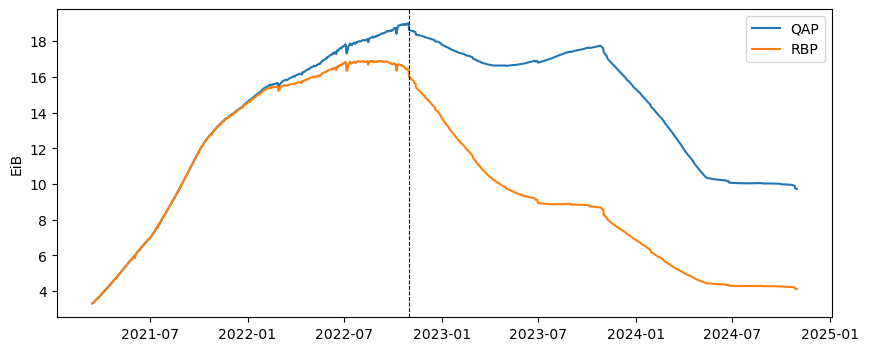

In [13]:
plt.figure(figsize=(10,4))
plt.plot(power_df['date'], power_df['total_qa_power_eib'], label="QAP")
plt.plot(power_df['date'], power_df['total_raw_power_eib'], label="RBP")
plt.axvline(power_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.ylabel("EiB")
plt.legend()
plt.show()

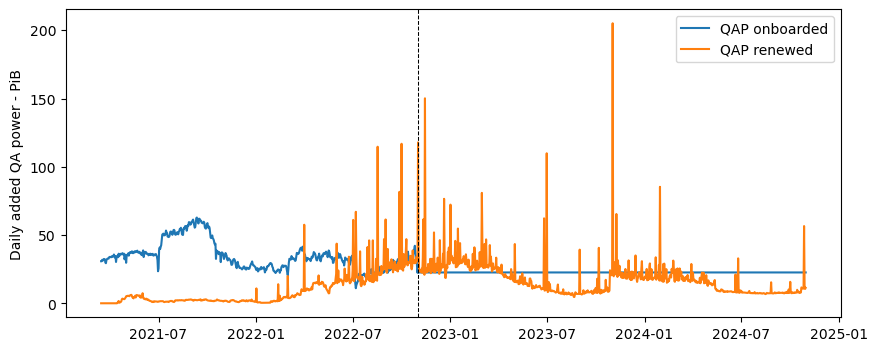

In [14]:
plt.figure(figsize=(10,4))
plt.plot(power_df['date'], power_df['day_onboarded_qa_power_pib'], label="QAP onboarded")
plt.plot(power_df['date'], power_df['day_renewed_qa_power_pib'], label="QAP renewed")
plt.axvline(power_df['date'][current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.ylabel("Daily added QA power - PiB")
plt.legend()
plt.show()

## 3. Forecast Vesting

In [15]:
vest_df = compute_vesting_trajectory_df(start_date, end_date)

print(len(vest_df))
vest_df.head()

1326


,date,total_vest
151,2021-03-15,1.093991e+08
152,2021-03-16,1.100472e+08
153,2021-03-17,1.106954e+08
154,2021-03-18,1.113435e+08
155,2021-03-19,1.119917e+08


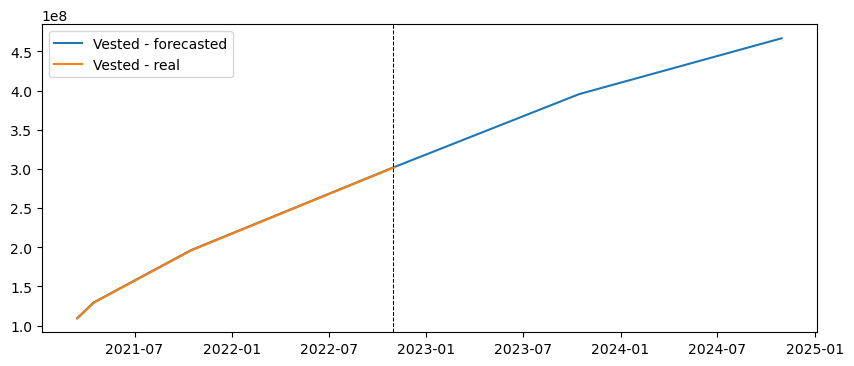

In [16]:
plt.figure(figsize=(10,4))
plt.plot(vest_df["date"], vest_df['total_vest'], label="Vested - forecasted")
plt.plot(fil_stats_df["date"], fil_stats_df['vested_fil'],label="Vested - real")
plt.axvline(vest_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()

## 4. Forecast minting stats and baseline

In [17]:
rb_total_power_eib = power_df["total_raw_power_eib"].values
qa_total_power_eib = power_df["total_qa_power_eib"].values
qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values

mint_df = compute_minting_trajectory_df(
    start_date,
    end_date,
    rb_total_power_eib,
    qa_total_power_eib,
    qa_day_onboarded_power_pib,
    qa_day_renewed_power_pib,
)

#### check network time

In [18]:
# if need to pull data to check network time
# from sqlalchemy import create_engine

# CONFIG_STRING_PATH = '../../../Data/Sentinel/config/sentinel_config.txt'
# with open(CONFIG_STRING_PATH, 'r') as fid:
#     conn_string = fid.read()
#     engine = create_engine(conn_string)
    
# model_ = 'chain_rewards'
# QUERY = f"""
# SELECT 
# to_timestamp(height_to_unix(height)) AS timestamp, cum_sum_baseline, cum_sum_realized, effective_baseline_power, new_baseline_power, total_mined_reward, effective_network_time 
# FROM visor.{model_}
# """
# pd.read_sql(QUERY, engine).to_csv(f'../../../Data/Sentinel/{model_}.csv')
# df_rewards_orig = pd.read_csv(f'../../../Data/Sentinel/{model_}.csv')

# rewards_df = df_rewards_orig.copy()
# rewards_df = rewards_df.sort_values("timestamp").reset_index()
# rewards_df['date'] = pd.to_datetime(rewards_df.timestamp, format='%Y-%m-%d')
# rewards_df = rewards_df.groupby(rewards_df.date.dt.date).mean() # daily so lighter weight
# rewards_df.index = pd.to_datetime(rewards_df.index, format='%Y-%m-%d')
# rewards_df.to_csv('../offline_info/chain_rewards.csv')

In [19]:
rewards_df = pd.read_csv('../offline_info/chain_rewards.csv', parse_dates=['date'])
rewards_df = rewards_df[rewards_df.date >= str(start_date)]
rewards_df.index = rewards_df.date

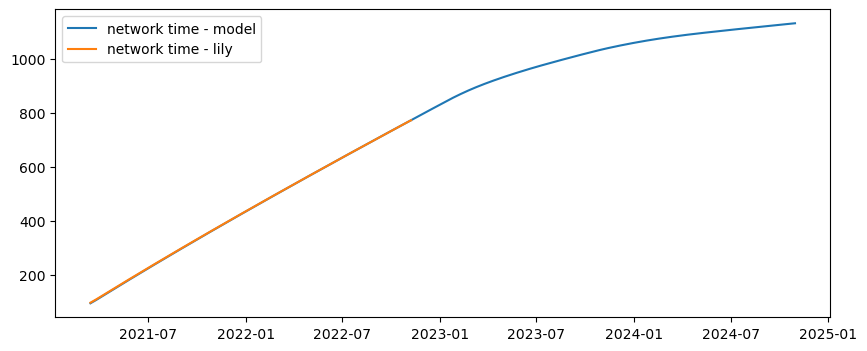

In [20]:
plt.figure(figsize=(10,4))
plt.plot(mint_df["date"], mint_df['network_time'], label="network time - model")
plt.plot(rewards_df.date, rewards_df["effective_network_time"]/(60*24*2), label="network time - lily");
plt.legend()
plt.show()

#### check baseline crossing

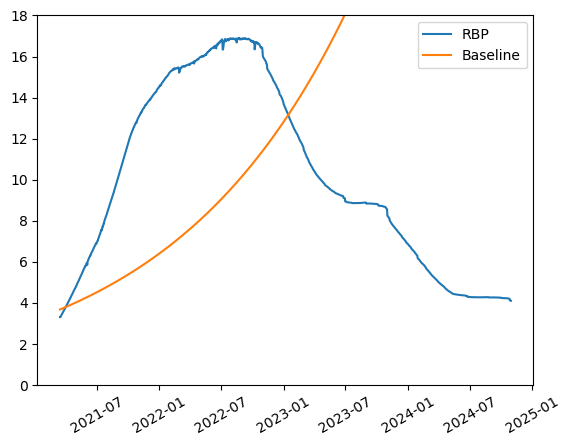

In [21]:
# BASELINE_B0 = 2.88888888 # should be this
BASELINE_B0 = 2.7636 # this value is required to match sentinel
BASELINE_R = np.log(2) / (2880*365) # 1_051_200 in eopchs
EPOCH_PER_DAY = 2880
def baseline_storage(epoch: float)->float:
    return BASELINE_B0 * np.exp(BASELINE_R * epoch)

# rewards_df.new_baseline_power.pipe(lambda x : x / (2**60)).plot()
# plt.plot(power_df.date, power_df.total_raw_power_eib)
# plt.plot(mint_df.date, baseline_storage(mint_df.days * EPOCH_PER_DAY))
# plt.xticks(rotation=30);
# plt.ylim(0,18)
plt.plot(power_df.date, power_df.total_raw_power_eib, label='RBP')
plt.plot(mint_df.date, baseline_storage(mint_df.days * EPOCH_PER_DAY), label='Baseline')
plt.xticks(rotation=30)
plt.ylim(0,18)
plt.legend()

# np.sum(rewards_df.new_baseline_power.pipe(lambda x : x / (2**60)).values[:500]-baseline_storage(mint_df.days * EPOCH_PER_DAY).values[:500])

#### check minting

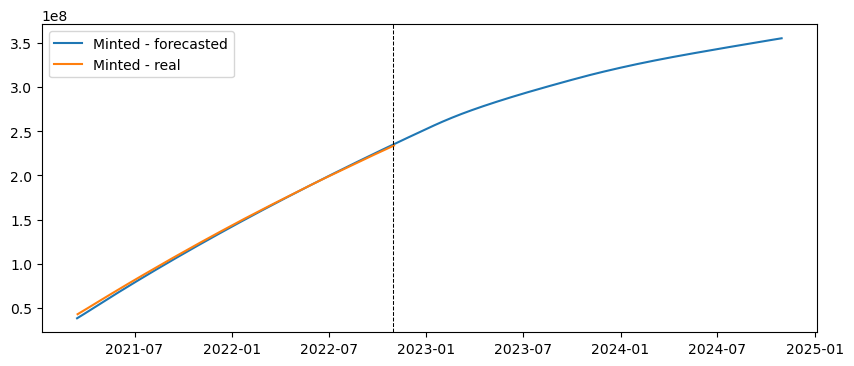

In [22]:
plt.figure(figsize=(10,4))
plt.plot(mint_df["date"], mint_df['cum_network_reward'], label="Minted - forecasted")
plt.plot(fil_stats_df["date"], fil_stats_df['mined_fil'],label="Minted - real")
plt.axvline(mint_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()

## 5. Compute circulating supply

In [23]:
print(len(renewal_rate_vec))

1326


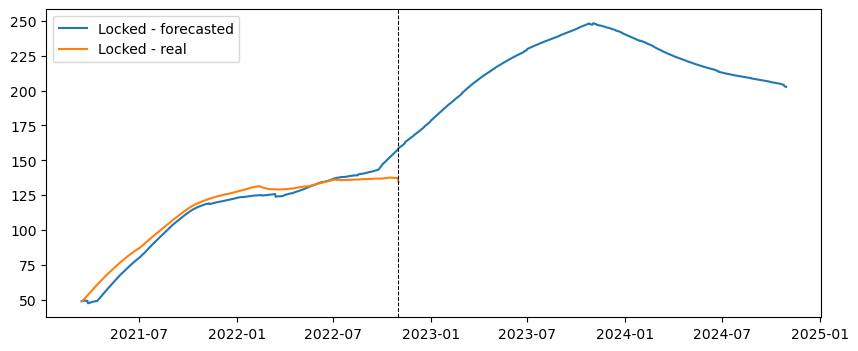

In [24]:
start_day_stats = fil_stats_df.iloc[0]
circ_supply_zero = start_day_stats["circulating_fil"]
locked_fil_zero = start_day_stats["locked_fil"]
burnt_fil_zero = start_day_stats["burnt_fil"]
daily_burnt_fil = fil_stats_df["burnt_fil"].diff().mean()
burnt_fil_vec = fil_stats_df["burnt_fil"].values

cil_df = forecast_circulating_supply_df(
    start_date,
    current_date,
    end_date,
    circ_supply_zero,
    locked_fil_zero,
    daily_burnt_fil,
    duration,
    renewal_rate_vec,
    burnt_fil_vec,
    vest_df,
    mint_df,
    known_scheduled_pledge_release_full_vec
)
MEGA = 10 ** 6
plt.figure(figsize=(10,4))
plt.plot(cil_df['date'], cil_df['network_locked'] / MEGA,label="Locked - forecasted")
plt.plot(fil_stats_df['date'], fil_stats_df['locked_fil'] / MEGA,label="Locked - real")
plt.axvline(cil_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()

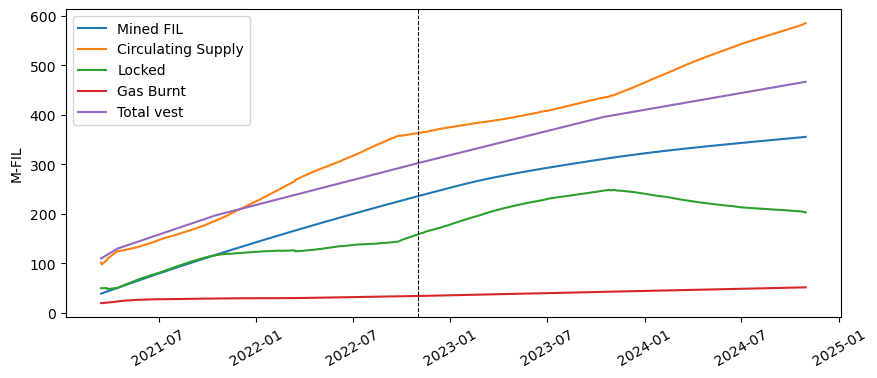

In [25]:
plt.figure(figsize=(10,4))
plt.plot(cil_df['date'], cil_df['cum_network_reward'] / MEGA,label='Mined FIL')
plt.plot(cil_df['date'], cil_df['circ_supply'] / MEGA,label="Circulating Supply")
plt.plot(cil_df['date'], cil_df['network_locked'] / MEGA,label="Locked")
plt.plot(cil_df['date'], cil_df['network_gas_burn'] / MEGA,label="Gas Burnt")
plt.plot(cil_df['date'], cil_df['total_vest'] / MEGA,label="Total vest")
plt.axvline(cil_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.xticks(rotation=30)
plt.ylabel("M-FIL")
plt.legend()
plt.show()

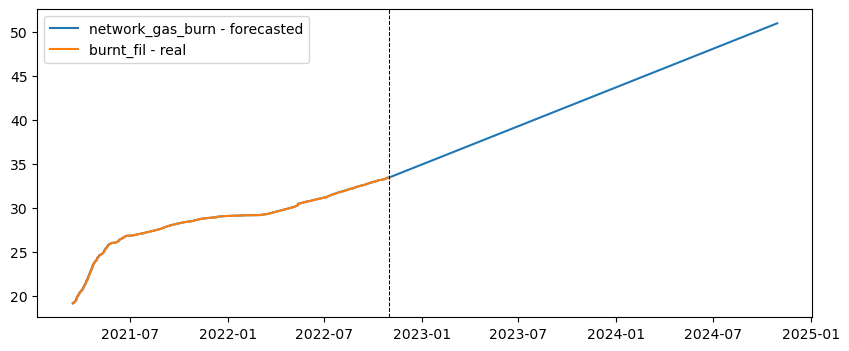

In [27]:
plt.figure(figsize=(10,4))
plt.plot(cil_df['date'], cil_df['network_gas_burn'] / MEGA,label="network_gas_burn - forecasted")
plt.plot(fil_stats_df['date'], fil_stats_df['burnt_fil'] / MEGA,label="burnt_fil - real")
plt.axvline(cil_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()

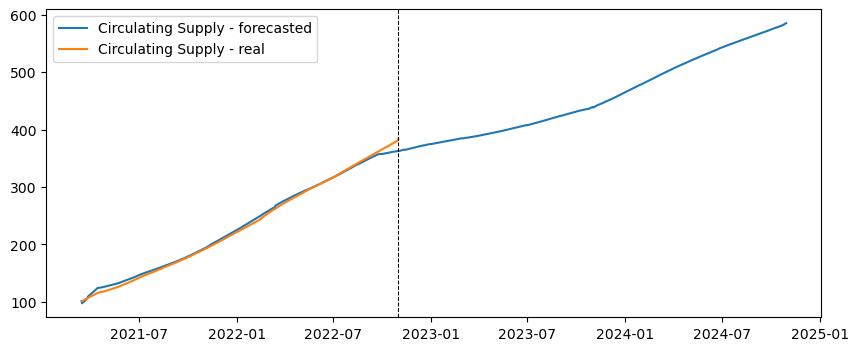

In [28]:
plt.figure(figsize=(10,4))
plt.plot(cil_df['date'], cil_df['circ_supply'] / MEGA,label="Circulating Supply - forecasted")
plt.plot(fil_stats_df['date'], fil_stats_df['circulating_fil'] / MEGA,label="Circulating Supply - real")
plt.axvline(cil_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()

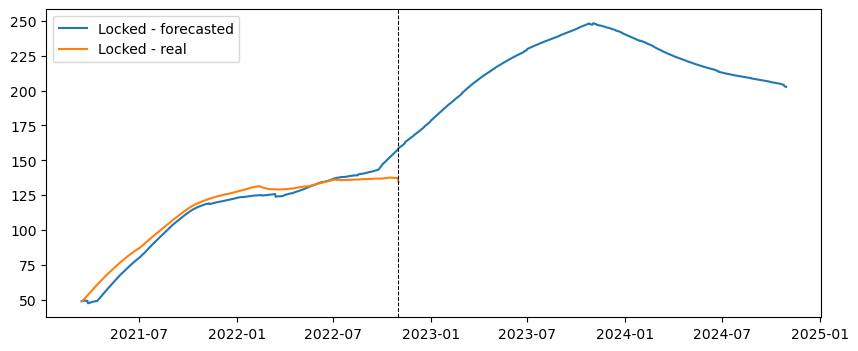

In [29]:
plt.figure(figsize=(10,4))
plt.plot(cil_df['date'], cil_df['network_locked'] / MEGA,label="Locked - forecasted")
plt.plot(fil_stats_df['date'], fil_stats_df['locked_fil'] / MEGA,label="Locked - real")
plt.axvline(cil_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()